In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

orders = pd.read_csv("../data/olist_orders_dataset.csv")
customers = pd.read_csv("../data/olist_customers_dataset.csv")
order_items = pd.read_csv("../data/olist_order_items_dataset.csv")

print("Datasets cargados.")



Datasets cargados.


In [2]:
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date"
]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])

orders = orders.dropna(subset=["order_delivered_customer_date"])

orders["delivery_time_days"] = (
    orders["order_delivered_customer_date"]
    - orders["order_purchase_timestamp"]
).dt.days

orders[["delivery_time_days"]].describe()


,delivery_time_days
count,96476.000000
mean,12.094086
std,9.551746
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


In [3]:
orders_customers = orders.merge(
    customers,
    on="customer_id",
    how="left"
)


In [4]:
order_summary = (
    order_items.groupby("order_id")
    .agg(
        total_items=("order_item_id", "count"),
        total_price=("price", "sum")
    )
    .reset_index()
)

delivery_df = orders_customers.merge(
    order_summary,
    on="order_id",
    how="left"
)

delivery_df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_items,total_price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,13,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,19.90


In [5]:
features = delivery_df[
    [
        "total_items",
        "total_price",
        "customer_state",
        "order_status"
    ]
]

target = delivery_df["delivery_time_days"]


In [6]:
numeric_features = ["total_items", "total_price"]
categorical_features = ["customer_state", "order_status"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42
)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVM": SVR()
}


In [9]:
results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    
    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df


,Model,MAE,RMSE,R2
0,Linear Regression,5.647638,9.138807,0.166255
3,Gradient Boosting,5.656246,9.226768,0.150128
5,SVM,5.388020,9.378532,0.121940
2,Random Forest,5.913081,9.675103,0.065530
4,KNN,6.183841,9.977957,0.006112
1,Decision Tree,6.211237,10.392050,-0.078094


In [10]:
best_model_name = results_df.iloc[0]["Model"]
best_model_name


'Linear Regression'

In [11]:
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", models[best_model_name])
])

best_pipeline.fit(X_train, y_train)
preds_best = best_pipeline.predict(X_test)


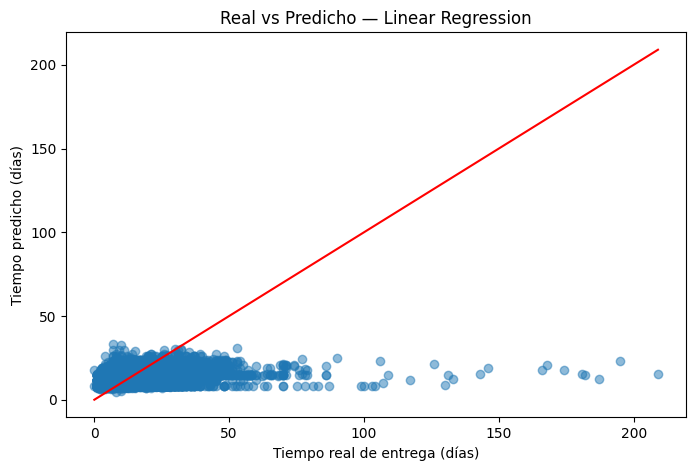

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, preds_best, alpha=0.5)
plt.xlabel("Tiempo real de entrega (días)")
plt.ylabel("Tiempo predicho (días)")
plt.title(f"Real vs Predicho — {best_model_name}")
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")
plt.show()
